# Влияние параметра f в расширенной системе


\begin{cases}
\displaystyle \frac{dx}{dt} = s\bigl(y - x\,y + x - q\,x^2\bigr), \\
\displaystyle \frac{dy}{dt} = s^{-1}\bigl(-y - x\,y + f\,z\bigr), \\
\displaystyle \frac{dz}{dt} = w\,(x - z).
\end{cases}


In [64]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.colors import LinearSegmentedColormap


def jacobian(f, t, y, eps=1e-8):
    m = len(y)
    J = np.zeros((m, m))
    f0 = f(t, y)
    for j in range(m):
        y_eps = y.copy()
        y_eps[j] += eps
        df = f(t, y_eps) - f0
        J[:, j] = df / eps
    return J


def irk2(f, y0, a, b, n=100, tol=1e-10, max_iter=50):
    h = (b - a) / n
    t = np.linspace(a, b, n + 1)
    m = len(y0)
    y = np.zeros((n + 1, m))
    y[0] = y0.copy()

    filename = f"data/irk2_{n}_{a}_{b}.csv"
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(y0)

        for i in range(n):
            ti, yi = t[i], y[i]
            ti1 = t[i + 1]
            Y = yi + h * f(ti, yi)

            for _ in range(max_iter):
                F = f(ti1, Y)
                G = Y - yi - (h / 2) * (f(ti, yi) + F)
                Jf = jacobian(f, ti1, Y)
                Jg = np.eye(m) - (h / 2) * Jf
                Jg += 1e-8 * np.eye(m)
                delta = np.linalg.solve(Jg, G)
                Y -= delta
                if np.linalg.norm(delta) < tol:
                    break

            y[i + 1] = Y
            writer.writerow(Y)

    return t, np.loadtxt(filename, delimiter=',')


def bdf2(f, y0, a, b, n=100, tol=1e-10, max_iter=50):
    h = (b - a) / n
    t = np.linspace(a, b, n + 1)
    m = len(y0)
    y = np.zeros((n + 1, m))
    y[0] = y0.copy()

    filename = f"data/bdf2_{n}_{a}_{b}.csv"
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(y0)

        t_start, y_start = irk2(f, y0, a, a + h, n=1, tol=tol, max_iter=max_iter)
        y[1] = y_start[-1]
        writer.writerow(y[1])

        alpha1, alpha2 = 4 / 3, -1 / 3
        beta = 2 / 3

        for i in range(1, n):
            ti1 = t[i + 1]
            y_nm1 = y[i - 1]
            y_n = y[i]

            Y = y_n + (y_n - y_nm1)

            for _ in range(max_iter):
                F = f(ti1, Y)
                G = Y - alpha1 * y_n - alpha2 * y_nm1 - beta * h * F
                Jf = jacobian(f, ti1, Y)
                Jg = np.eye(m) - beta * h * Jf
                Jg += 1e-8 * np.eye(m)
                delta = np.linalg.solve(Jg, G)
                Y -= delta
                if np.linalg.norm(delta) < tol:
                    break

            y[i + 1] = Y
            writer.writerow(Y)

    return t, np.loadtxt(filename, delimiter=',')

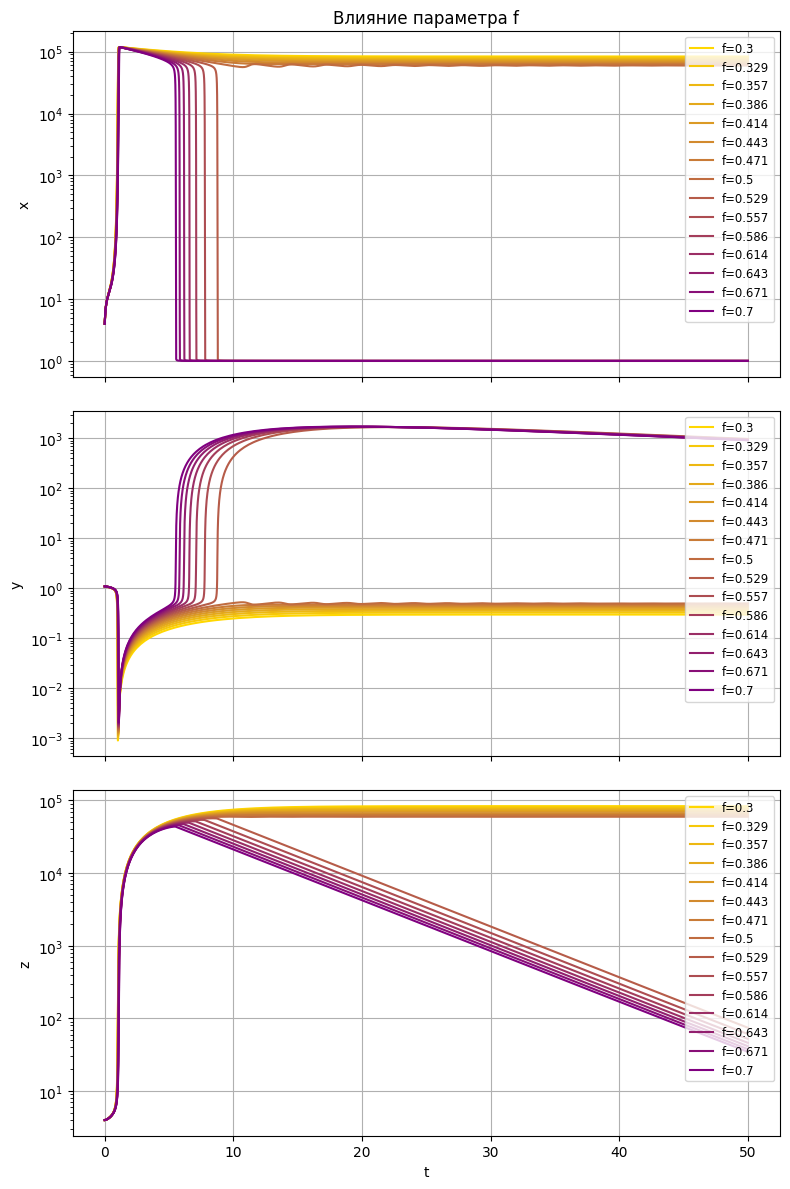

In [65]:
base = {
    's': 77.27,
    'q': 8.375e-6,
    'f': 1.0,
    'w': 0.161,
}

K = 15

deltas = {
    key: np.linspace(0.3 * val, 0.7 * val, K)
    for key, val in base.items()
}

y0 = [4.0, 1.1, 4.0]
t_span = (0.0, 50.0)

colors = ["#FFD700", "#800080"]
cmap = LinearSegmentedColormap.from_list("yellow_purple", colors, N=K)


def build_f(params):
    def f(t, y):
        x, y_var, z = y
        s = params['s']
        q = params['q']
        f = params['f']
        w = params['w']
        dx = s * (y_var - x * y_var + x - q * x ** 2)
        dy = (1 / s) * (-y_var - x * y_var + f * z)
        dz = w * (x - z)
        return [dx, dy, dz]

    return f


def run_colormap(vary_param):
    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
    labels = ['x', 'y', 'z']
    for idx, new_val in enumerate(deltas[vary_param]):
        params = base.copy()
        params[vary_param] = new_val
        f = build_f(params)

        sol = solve_ivp(f, t_span, y0, method='BDF',
                        atol=1e-8, rtol=1e-6)
        t = sol.t
        Y = sol.y.T

        for ax_idx, ax in enumerate(axes):
            ax.plot(t, Y[:, ax_idx],
                    color=cmap(idx),
                    label=f"{vary_param}={new_val:.3g}")
            ax.set_ylabel(labels[ax_idx])
            ax.set_yscale('log')
            ax.grid(True)

    axes[-1].set_xlabel("t")
    axes[0].set_title(f"Влияние параметра {vary_param}")
    for ax in axes:
        ax.legend(fontsize='small', loc='upper right')
    plt.tight_layout()
    plt.show()
for param in ['f']:
    run_colormap(param)